In [7]:
import numpy as np

#from deslib.static.oracle import Oracle
from ensemble.oracle import Oracle

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
from sklearn.linear_model import Perceptron # base classifier
from sklearn.linear_model import SGDClassifier # base classifier

#from ensemble.random_oracle_alt import RandomOracleModel
from ensemble.random_linear_oracle import RandomOracleModel

from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import utils
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer


In [8]:
ds_name, X, y = utils.data_wine()

seed = 100000
pool_length = [10, 20, 30, 40, 50, 60, 80, 90, 100]
np.random.seed(seed)
#base_learner = SGDClassifier(loss="perceptron", eta0=1.e-17,max_iter=200, learning_rate="constant", penalty=None)
base_learner = Perceptron(max_iter=200)
pool_type = 'random_subspace'

print("Dataset size: %d" % X.shape[0])

kf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
#kf = KFold(n_splits=5)

Dataset size: 178


In [9]:
"""
    With random Subspaces, estimators differentiate because of random subsets of the features.
    We can implement the random subspace ensemble using Bagging in scikit-learn, by keeping all training instances 
    but sampling features. According to (Aurlien, 2017, p. 188), we can achieve it by setting "bootstrap=False", "max_samples=1.0", 
    and "bootstrap_features=True"

    Reference: 
    Aurlien Gron. 2017. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques 
    to Build Intelligent Systems (1st. ed.). O'Reilly Media, Inc.
"""
results = {'oracle_accuracy': [], 'ensemble_length': [], 'fold': []}

for l in tqdm(pool_length):    
    pool_types = {
        'bagging': BaggingClassifier(base_estimator=base_learner, n_estimators=l),
        'adaboost': AdaBoostClassifier(base_estimator=base_learner, n_estimators=l, algorithm='SAMME'),
        'random_subspace': BaggingClassifier(base_estimator=base_learner, n_estimators=l, bootstrap=False, 
                                            max_samples=1.0, max_features=0.50),
        'random_oracle_model': RandomOracleModel(base_estimator=base_learner, n_estimators=l)
    }

    pool_classifiers = pool_types[pool_type]
    scores = list()
    
    fold = 0
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    

        pool_classifiers.fit(X_train, y_train)
        oracle = Oracle(pool_classifiers)
        
        
        if pool_type is 'random_subspace':
            #print(pool_classifiers.estimators_features_)
            #print(X_test[np.concatenate((pool_classifiers.estimators_features_))])            
            
            #score = oracle.score(X_test[np.random.permutation(len(X_test))][:, 0:int(0.50*X_test.shape[1])], y_test)            
            
            #base_scores = []
            #for i in range(0,l):
            #    base_score = oracle.score(X_test[pool_classifiers.estimators_features_[i]].T, y_test)
            #    base_scores.append(base_score)
            #score = np.mean(base_scores)                        
            
            score = oracle.score_rs(X_test, y_test, pool_classifiers.estimators_features_)
            
            
        elif pool_type is 'random_oracle_model':
            score = pool_classifiers.score(X_test, y_test)
        else:
            score = oracle.score(X_test, y_test)
    
        
        results['oracle_accuracy'].append(score)
        results['ensemble_length'].append(l)
        results['fold'].append(fold)
        fold += 1
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]


In [10]:
df = pd.DataFrame(results)
df_new = pd.DataFrame()
for pl in pool_length:    
    df_new[pl] = list(df[df.ensemble_length == pl].oracle_accuracy.values)

In [11]:
pd.concat([df.groupby(['ensemble_length']).mean()['oracle_accuracy'], 
           df.groupby(['ensemble_length']).std()['oracle_accuracy']], axis=1).\
            to_csv("results/%s_%s.csv" % (ds_name, pool_type))

In [12]:
df_new

,10,20,30,40,50,60,80,90,100
0,0.055556,0.083333,0.111111,0.111111,0.111111,0.083333,0.083333,0.083333,0.111111
1,0.083333,0.083333,0.111111,0.138889,0.083333,0.138889,0.138889,0.083333,0.222222
2,0.055556,0.055556,0.083333,0.111111,0.083333,0.083333,0.111111,0.111111,0.111111
3,0.057143,0.085714,0.085714,0.057143,0.085714,0.114286,0.114286,0.171429,0.114286
4,0.057143,0.085714,0.085714,0.114286,0.085714,0.085714,0.085714,0.085714,0.114286


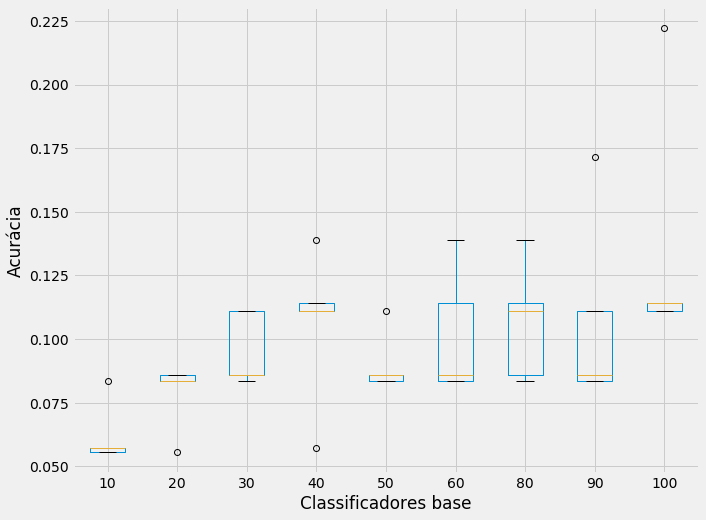

In [13]:
with plt.style.context('fivethirtyeight'):
    df_new.boxplot(figsize=(10,8), grid=True)
    #plt.title('Dispersão nos escores')
    plt.xlabel('Classificadores base')
    plt.ylabel('Acurácia')
    plt.savefig("results/%s_%s.pdf" % (ds_name, pool_type))
    plt.show();

In [14]:
df

,oracle_accuracy,ensemble_length,fold
0,0.055556,10,0
1,0.083333,10,1
2,0.055556,10,2
3,0.057143,10,3
4,0.057143,10,4
5,0.083333,20,0
6,0.083333,20,1
7,0.055556,20,2
8,0.085714,20,3
9,0.085714,20,4
